In [1]:
from molmap import loadmap
from joblib import load, dump
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
import warnings, os
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm

from aggmap.show import imshow, imshow_wrap
from aggmap.utils.matrixopt import smartpadding

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
def CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False):
    '''
    Forward prop. Feature importance
    '''
    
    if task_type == 'classification':
        f = log_loss
    else:
        f = mean_squared_error
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    grid = mp.plot_grid()
    Y_true = dfY.values
    df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = model.predict(arrX)
    N, W, H, C = arrX.shape
    
    if (sigmoidy) & (task_type == 'classification'):
        Y_prob = sigmoid(Y_prob)

    final_res = {}
    for k, col in enumerate(dfY.columns):
        print('calculating feature importance for %s ...' % col)
        
        results = []
        loss = f(Y_true[:, k].tolist(), Y_prob[:, k].tolist())
        for i in tqdm(range(len(df_grid)), ascii= True):
            ts = df_grid.iloc[i]
            y = ts.y
            x = ts.x
            X1 = copy(arrX)
            X1[:, y, x,:] = np.full(X1[:, y, x,:].shape, fill_value = arrX.min())
            #Y1 = model.predict(X1)
            Y_pred_prob = model.predict(X1)
            if (sigmoidy) & (task_type == 'classification'):
                Y_pred_prob = sigmoid(Y_pred_prob)
            mut_loss = f(Y_true[:, k].tolist(), Y_pred_prob[:, k].tolist()) 
            res =  mut_loss - loss # if res > 0, important, othervise, not important
            results.append(res)
            
        final_res.update({col:results})
    df = pd.DataFrame(final_res)
    df.columns = df.columns + '_importance'
    df = df_grid.join(df)
    return df


def CalcFeatImpEachImg(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False):
    '''
    Forward prop. Feature importance
    '''
    
    assert len(arrX) == 1, 'each for only one image!'
    
    if task_type == 'classification':
        f = log_loss
    else:
        f = mean_squared_error
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    grid = mp.plot_grid()
    Y_true = dfY.values
    df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = model.predict(arrX)
    N, W, H, C = arrX.shape

    if (sigmoidy) & (task_type == 'classification'):
        Y_prob = sigmoid(Y_prob)

    results = []
    loss = f(Y_true.ravel().tolist(),  Y_prob.ravel().tolist())
    for i in tqdm(range(len(df_grid)), ascii= True):
        ts = df_grid.iloc[i]
        y = ts.y
        x = ts.x
        X1 = copy(arrX)
        X1[:, y, x,:] = np.full(X1[:, y, x,:].shape, fill_value = arrX.min())
        #Y1 = model.predict(X1)
        Y_pred_prob = model.predict(X1)
        if (sigmoidy) & (task_type == 'classification'):
            Y_pred_prob = sigmoid(Y_pred_prob)
        mut_loss = f(Y_true.ravel().tolist(), Y_pred_prob.ravel().tolist()) 
        res =  mut_loss - loss # if res > 0, important, othervise, not important
        results.append(res)
 
     
    df = pd.DataFrame(results, columns = ['imp'])
    #df.columns = df.columns + '_importance'
    df = df_grid.join(df)
    return df

In [3]:
from config import P
data_save_folder = P.mnist_data_save_folder
mnist_labels_dict = P.mnist_labels_dict

results_save_folder = P.results_save_folder
color_list = P.color_list


In [5]:
os.path.join(data_save_folder, 'mp_ORSAgg1.mp')

'/raid/shenwanxiang/aggmap/mnist/correlation/mp_ORSAgg1.mp'

In [5]:
#agg
X_ORSAgg1 = load(os.path.join(data_save_folder, '03_X_ORSAgg1.data'))

#cluster split channel
X_ORSAggC5 = load(os.path.join(data_save_folder, '04_X_ORSAggC5.data'))


mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC5 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))

model_OR1 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_Org1.h5')) 
model_ORSAgg1 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_OrgRPAgg1.h5')) 
model_ORSAggC5 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_OrgRPAgg5.h5'))

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #(x_train, y_train), (x_test, y_test)
trainY = pd.get_dummies(y_train).values.astype(float)
testY = pd.get_dummies(y_test).values.astype(float)


# 1. OVERALL-interpret ORSAgg-1

In [6]:
name = 'ORSAgg1'

model = model_ORSAgg1
mp = mp_ORSAgg1
trainX, testX = X_ORSAgg1


X = testX
Y = testY

arrX = X / 255.

dfY = pd.DataFrame(Y, columns = ['label_%s' % i for i in range(Y.shape[-1])])

dfimp_overall = CalcFeatImp(model, mp, arrX, dfY, task_type='classification', sigmoidy=False)


2020-10-19 18:56:09,247 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-19 18:56:09,269 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_0 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_1 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_2 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_3 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_4 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_5 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_6 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_7 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_8 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_9 ...


100%|##########| 729/729 [08:04<00:00,  1.50it/s]


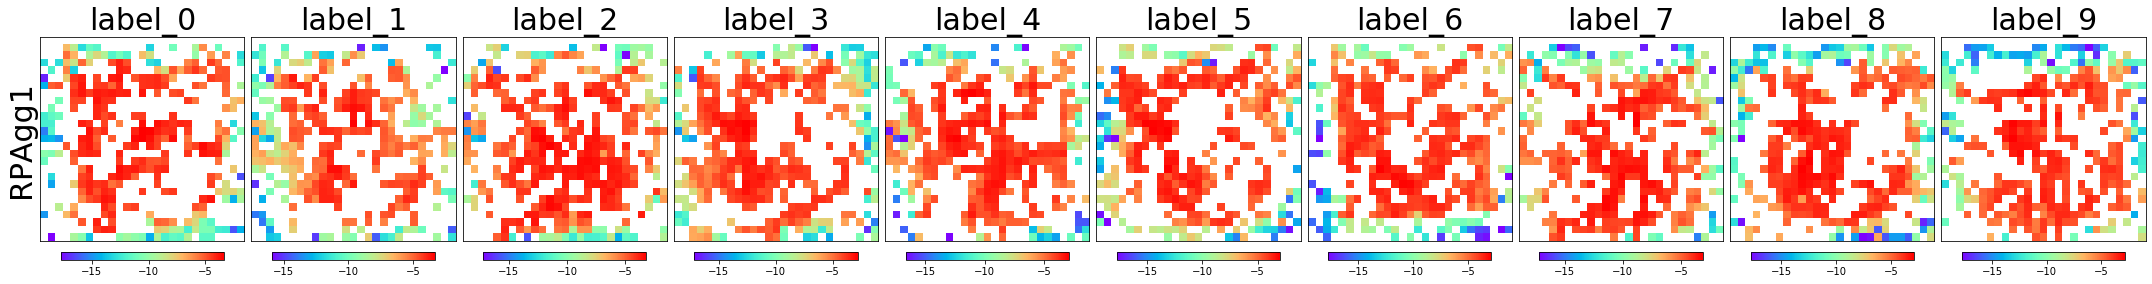

In [7]:
fig, axes = plt.subplots(nrows= 1, ncols= 10, figsize=(30, 4), sharex = False, sharey = False)

row = 'RPAgg1'
for ax, col in zip(axes, dfimp_overall.columns[-10:]):
    IMP = dfimp_overall[col].values.reshape(mp._S.fmap_shape)
    #fig, ax  = plt.subplots(1, 1, figsize=(7, 6))
    PCM = ax.imshow(np.log10(IMP), cmap = 'rainbow') #
    ax.set_xticks([]) 
    ax.set_yticks([])
    clb = plt.colorbar(PCM, ax = ax, shrink = 0.8, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    #clb.ax.set_title('log importance')

cols = ['label_%s' % i for i in range(Y.shape[-1])]
for ax, col in zip(axes, cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
    

axes[0].set_ylabel(row, fontsize = 30)  

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)

fig.savefig(os.path.join(results_save_folder, 'xAI_overall_%s.png' % name), bbox_inches='tight', dpi=400) 

# 2. OVERALL-interpret ORSAgg-5

In [7]:
name = 'ORSAgg5'

model = model_ORSAggC5
mp = mp_ORSAggC5
trainX, testX = X_ORSAggC5


X = testX
Y = testY

arrX = X / 255.

dfY = pd.DataFrame(Y, columns = ['label_%s' % i for i in range(Y.shape[-1])])

dfimp_overall2 = CalcFeatImp(model, mp, arrX, dfY, task_type='classification', sigmoidy=False)


2020-10-20 10:48:32,030 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 10:48:32,057 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_0 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_1 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_2 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_3 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_4 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_5 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_6 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_7 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_8 ...


  0%|          | 0/729 [00:00<?, ?it/s]

calculating feature importance for label_9 ...


100%|##########| 729/729 [12:38<00:00,  1.04s/it]


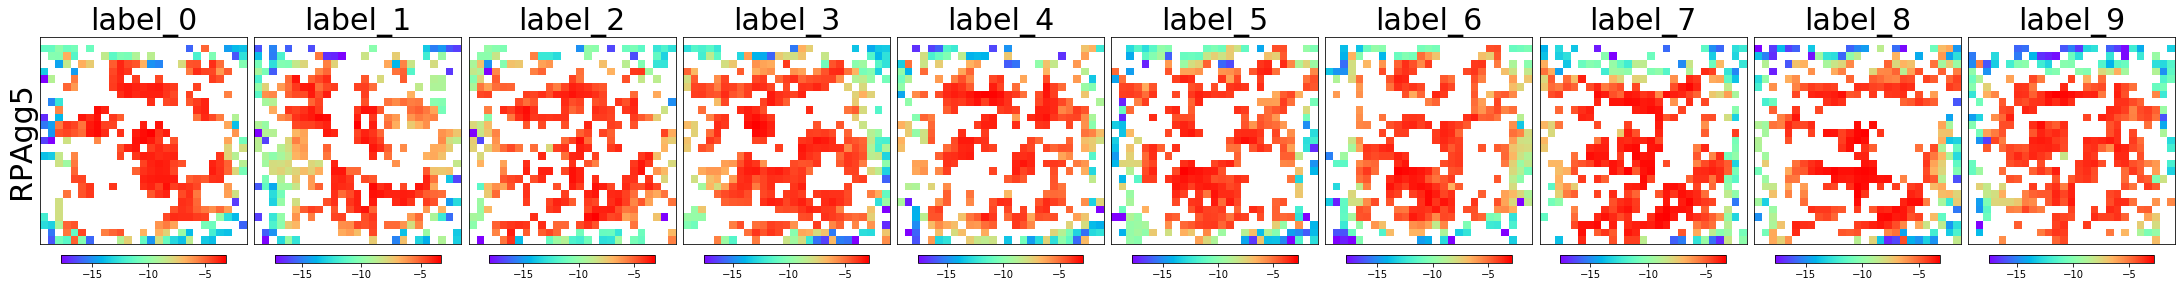

In [8]:
fig, axes = plt.subplots(nrows= 1, ncols= 10, figsize=(30, 4), sharex = False, sharey = False)
for ax, col in zip(axes, dfimp_overall2.columns[-10:]):
    IMP = dfimp_overall2[col].values.reshape(mp._S.fmap_shape)
    #fig, ax  = plt.subplots(1, 1, figsize=(7, 6))
    PCM = ax.imshow(np.log10(IMP), cmap = 'rainbow') #
    ax.set_xticks([]) 
    ax.set_yticks([])
    clb = plt.colorbar(PCM, ax = ax, shrink = 0.8, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    #clb.ax.set_title('log importance')

cols = ['label_%s' % i for i in range(Y.shape[-1])]
for ax, col in zip(axes, cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
    
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)

row = 'RPAgg5'
axes[0].set_ylabel(row, fontsize = 30) 
fig.savefig(os.path.join(results_save_folder, 'xAI_overall_%s.png' % name), bbox_inches='tight', dpi=400) 

In [9]:
label_idxs = pd.Series(y_test).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())
image_idx = [pd.Series(label_idxs[i][:1]).sample(1, random_state = 1).to_list()[0] for i in range(len(label_idxs))]
image_idx

[3, 2, 1, 18, 4, 8, 11, 0, 61, 7]

# 3. Test Set: OneImage-interpret ORSAgg-1

2020-10-20 12:55:00,114 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:55:00,130 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:37<00:00, 19.68it/s]


2020-10-20 12:55:37,934 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:55:37,951 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.72it/s]


2020-10-20 12:56:04,909 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:56:04,929 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:31<00:00, 23.33it/s]


2020-10-20 12:56:36,756 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:56:36,776 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.98it/s]


2020-10-20 12:57:03,385 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:57:03,402 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.81it/s]


2020-10-20 12:57:30,104 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:57:30,121 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:32<00:00, 22.39it/s]


2020-10-20 12:58:03,140 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:58:03,156 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.83it/s]


2020-10-20 12:58:29,759 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:58:29,776 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:25<00:00, 28.06it/s]


2020-10-20 12:58:56,133 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:58:56,151 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:33<00:00, 21.77it/s]


2020-10-20 12:59:29,984 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 12:59:30,001 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.79it/s]


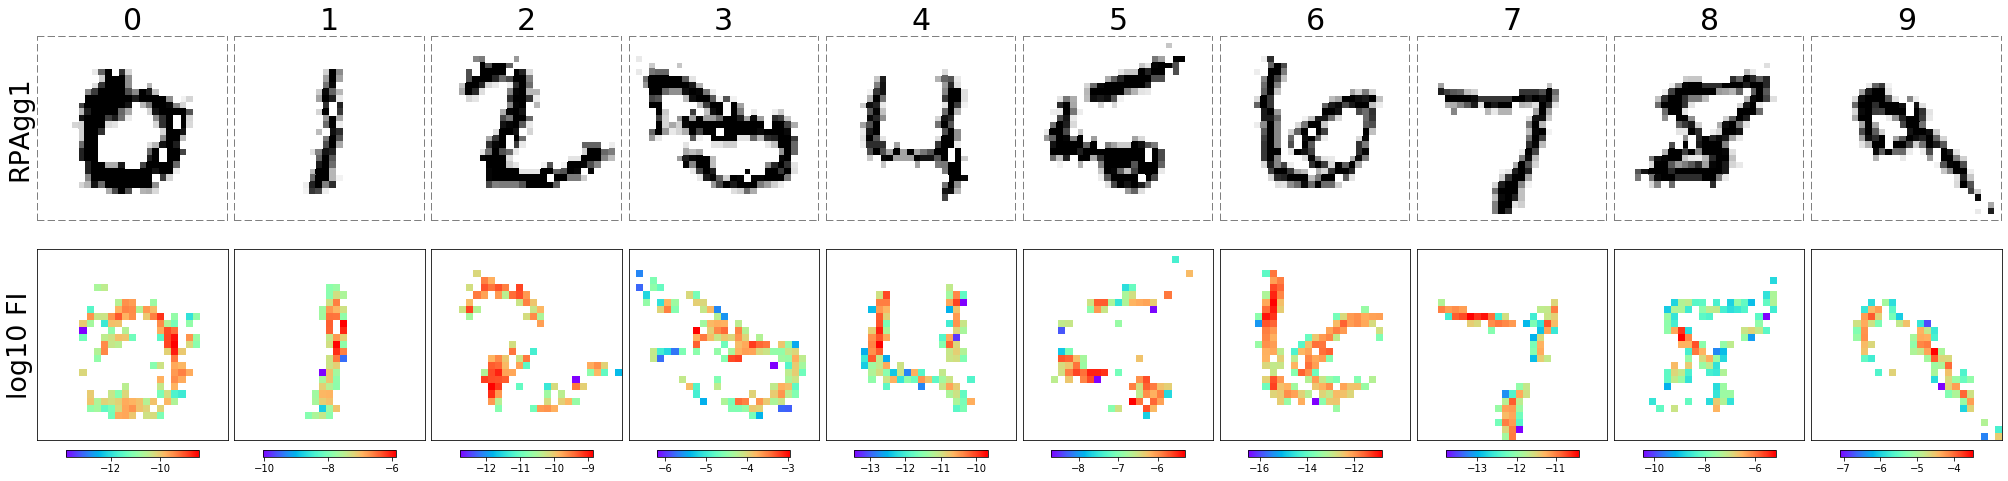

In [10]:
name = 'RPAgg1'
fontsize = 27

model = model_ORSAgg1
mp = mp_ORSAgg1
trainX, testX = X_ORSAgg1

fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), sharex = False, 
                         sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})


rows = ['RPAgg1', 'log10 FI']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 

for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = ['black'], x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEachImg(model, mp, arrX, dfY, )
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    
    IMP = smartpadding(np.log10(IMPM), arrX[0].shape[:-1], constant_values = np.log10(IMPM).min())

    PCM = ax2.imshow(np.log10(IMPM), cmap = 'rainbow')
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(results_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 

# 4. Test Set: OneImage-interpret ORSAgg-C5

2020-10-20 13:00:07,920 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:00:07,941 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.94it/s]


2020-10-20 13:00:35,856 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:00:35,879 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.93it/s]


2020-10-20 13:01:03,680 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:01:03,705 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.86it/s]


2020-10-20 13:01:31,482 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:01:31,504 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:35<00:00, 20.42it/s]


2020-10-20 13:02:08,733 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:02:08,755 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.79it/s]


2020-10-20 13:02:36,429 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:02:36,451 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.85it/s]


2020-10-20 13:03:03,926 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:03:03,948 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.90it/s]


2020-10-20 13:03:31,298 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:03:31,322 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.74it/s]


2020-10-20 13:03:58,731 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:03:58,757 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:37<00:00, 19.47it/s]


2020-10-20 13:04:37,201 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:04:37,224 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.62it/s]


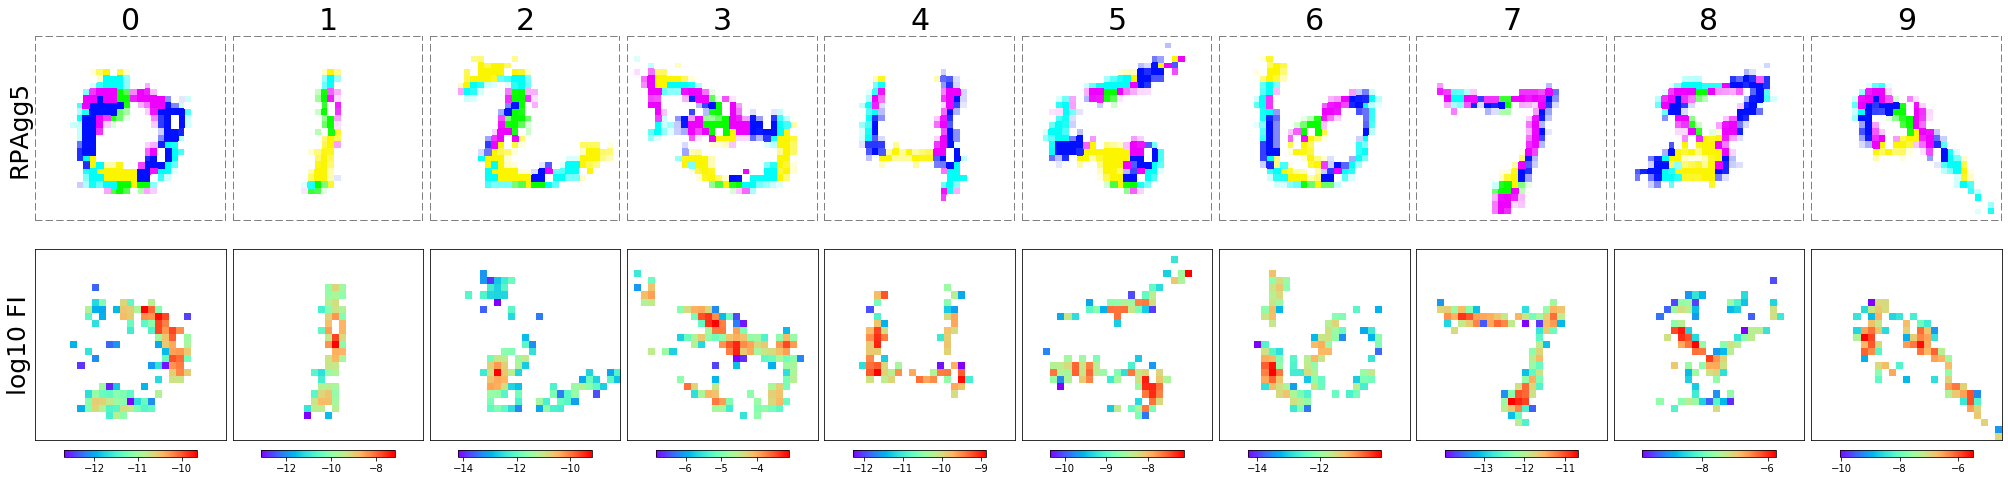

In [11]:
name = 'RPAgg5'

model = model_ORSAggC5
mp = mp_ORSAggC5
trainX, testX = X_ORSAggC5
    
fontsize = 25

fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), 
                         sharex = False, sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})


rows = ['RPAgg5', 'log10 FI']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 


for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = pd.Series(mp.colormaps).tolist(), x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEachImg(model, mp, arrX, dfY, )
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    
    IMP = smartpadding(np.log10(IMPM), arrX[0].shape[:-1], constant_values = np.log10(IMPM).min())

    PCM = ax2.imshow(np.log10(IMPM), cmap = 'rainbow')
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(results_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 

# 5. Test Set: OneImage-interpret ORSAgg1, Gauss noisy 0.36

2020-10-20 13:05:14,423 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:05:14,440 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.76it/s]


2020-10-20 13:05:41,343 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:05:41,363 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.80it/s]


2020-10-20 13:06:08,172 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:06:08,188 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.80it/s]


2020-10-20 13:06:34,970 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:06:34,987 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.95it/s]


2020-10-20 13:07:01,605 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:07:01,622 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:40<00:00, 18.09it/s]


2020-10-20 13:07:42,417 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:07:42,436 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.72it/s]


2020-10-20 13:08:09,178 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:08:09,195 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.90it/s]


2020-10-20 13:08:35,757 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:08:35,774 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.79it/s]


2020-10-20 13:09:02,391 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:09:02,408 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.84it/s]


2020-10-20 13:09:28,950 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:09:28,966 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.67it/s]


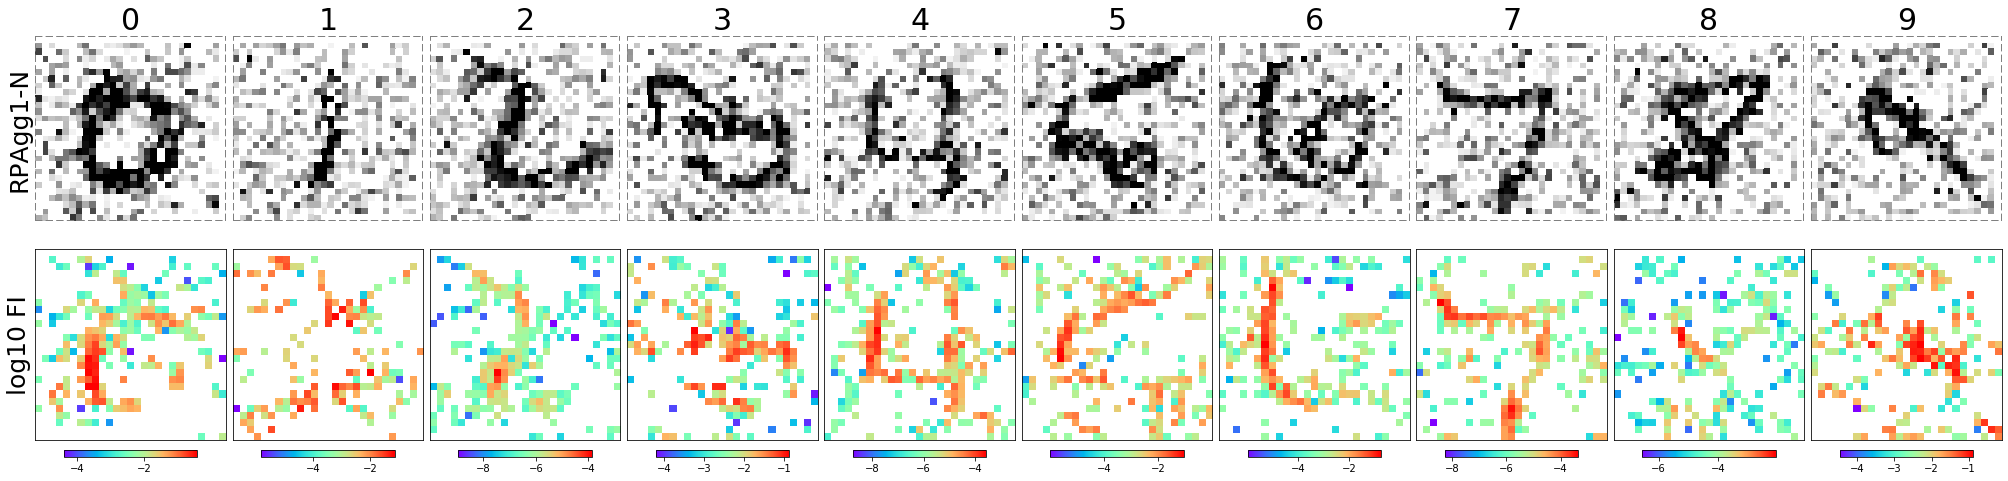

In [12]:
testX_noisys_shuffle_ORSAgg1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAgg1.data')) 
testX = testX_noisys_shuffle_ORSAgg1[3] #stddev = 0.36
name = 'RPAgg1-Gauss-0.36'

model = model_ORSAgg1
mp = mp_ORSAgg1
fontsize = 25

fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), sharex = False, sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})

rows = ['RPAgg1-N', 'log10 FI']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 


for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = ['black'], x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEachImg(model, mp, arrX, dfY, )
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    
    IMP = smartpadding(np.log10(IMPM), arrX[0].shape[:-1], constant_values = np.log10(IMPM).min())

    PCM = ax2.imshow(np.log10(IMPM), cmap = 'rainbow')
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(results_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 

# 6. Test Set: OneImage-interpret ORSAgg5, Gauss noisy 0.36

2020-10-20 13:10:08,312 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:10:08,334 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.93it/s]


2020-10-20 13:10:36,233 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:10:36,254 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.75it/s]


2020-10-20 13:11:04,267 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:11:04,290 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.84it/s]


2020-10-20 13:11:32,092 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:11:32,116 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:43<00:00, 16.73it/s]


2020-10-20 13:12:17,194 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:12:17,216 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.83it/s]


2020-10-20 13:12:44,810 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:12:44,832 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.79it/s]


2020-10-20 13:13:12,361 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:13:12,383 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.75it/s]


2020-10-20 13:13:39,814 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:13:39,838 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.69it/s]


2020-10-20 13:14:07,247 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:14:07,269 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.98it/s]


2020-10-20 13:14:34,337 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2020-10-20 13:14:34,360 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:26<00:00, 27.75it/s]


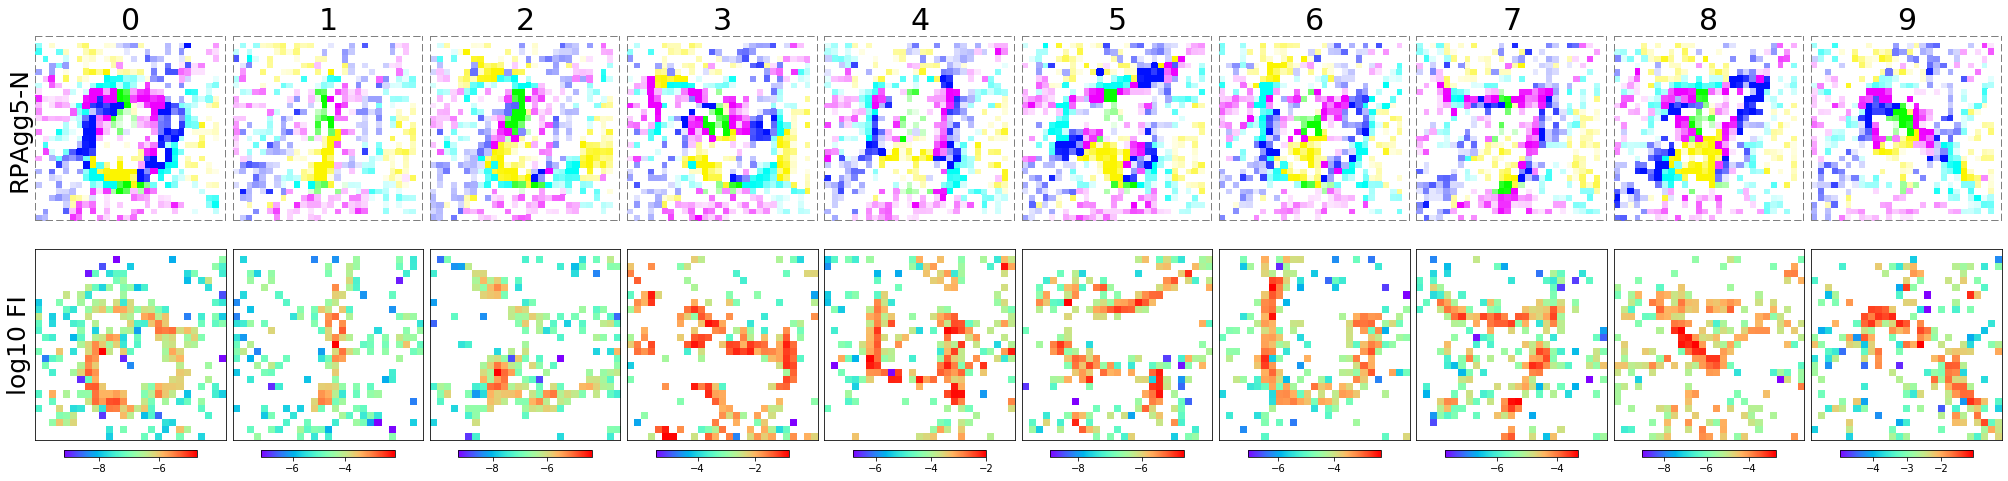

In [13]:
testX_noisys_shuffle_ORSAggC5 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC5.data')) 
testX = testX_noisys_shuffle_ORSAggC5[3] #stddev = 0.36
name = 'RPAgg5-Gauss-0.36'

model = model_ORSAggC5
mp = mp_ORSAggC5
fontsize = 25



fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), sharex = False, sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})
rows = ['RPAgg5-N', 'log10 FI']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 


for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = pd.Series(mp.colormaps).tolist(), x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEachImg(model, mp, arrX, dfY, )
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    
    IMP = smartpadding(np.log10(IMPM), arrX[0].shape[:-1], constant_values = np.log10(IMPM).min())

    PCM = ax2.imshow(np.log10(IMPM), cmap = 'rainbow')
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(results_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 